In [4]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [5]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader



In [6]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [7]:
comp = [
     #'England'
     #'France',
     #'Germany',
     #'Italy',
     'Spain'
]

In [8]:
##DA qui

In [9]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [10]:
selected_competitions = competitions[(competitions['country_name'] =='Spain')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
2,795,181144,Spain,Spanish first division,male,2017/2018


### Append home and away goals to the game dataset

In [11]:
## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in selected_competitions['country_name']:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)
df_matches= df_matches.reset_index()

In [12]:
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    home_score.append(df_matches['teamsData'][i][home_id]['score'])
    away_score.append(df_matches['teamsData'][i][away_id]['score'])


In [13]:
df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

In [14]:
df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181144,2565922,"Barcelona - Real Sociedad, 1 - 0",795,1,0
1,181144,2565925,"Atl\u00e9tico Madrid - Eibar, 2 - 2",795,2,2
2,181144,2565919,"Athletic Club - Espanyol, 0 - 1",795,0,1
3,181144,2565924,"Valencia - Deportivo La Coru\u00f1a, 2 - 1",795,2,1
4,181144,2565927,"Villarreal - Real Madrid, 2 - 2",795,2,2


In [15]:
# Get games from all selected competitions
games = pd.concat([
    wyscout.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])

In [16]:
games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2565922,795,181144,2018-05-20 18:45:00,38,676,687
1,2565925,795,181144,2018-05-20 16:30:00,38,679,701
2,2565919,795,181144,2018-05-20 14:15:00,38,678,691
3,2565924,795,181144,2018-05-20 10:00:00,38,674,677
4,2565927,795,181144,2018-05-19 18:45:00,38,682,675


In [17]:
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [18]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,676,687,2018-05-20 18:45:00,1,0
1,679,701,2018-05-20 16:30:00,2,2
2,678,691,2018-05-20 14:15:00,0,1
3,674,677,2018-05-20 10:00:00,2,1
4,682,675,2018-05-19 18:45:00,2,2
...,...,...,...,...,...
375,680,691,2017-08-19 20:15:00,1,1
376,756,679,2017-08-19 18:15:00,2,2
377,692,687,2017-08-19 16:15:00,2,3
378,674,714,2017-08-18 20:15:00,1,0


In [19]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


### Convert event to actions

In [20]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Spa"

In [21]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [22]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,676,Barcelona,FC Barcelona
1,687,Real Sociedad,Real Sociedad de F\u00fatbol
2,679,Atl\u00e9tico Madrid,Club Atl\u00e9tico de Madrid
3,701,Eibar,SD Eibar
4,691,Espanyol,Reial Club Deportiu Espanyol
5,678,Athletic Club,Athletic Club Bilbao
6,674,Valencia,Valencia Club de F\u00fatbol
7,677,Deportivo La Coru\u00f1a,Real Club Deportivo de La Coru\u00f1a
8,675,Real Madrid,Real Madrid Club de F\u00fatbol
9,682,Villarreal,Villarreal Club de F\u00fatbol


In [23]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "Spain") 
                  & (games.home_team_name_short == "Barcelona")
                  & (games.away_team_name_short== "Real Madrid")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2565907,249644096,0,1,3.274992,675,3321,52.50,33.32,13.65,-6.12,0,0,pass,foot,K. Benzema,Real Madrid,Real Madrid Club de F\u00fatbol
1,2565907,249644096,1,1,4.192094,675,14723,66.15,27.20,0.00,0.00,23,0,receival,foot,T. Kroos,Real Madrid,Real Madrid Club de F\u00fatbol
2,2565907,249644097,2,1,5.109197,675,14723,66.15,27.20,7.35,-11.56,0,0,pass,foot,T. Kroos,Real Madrid,Real Madrid Club de F\u00fatbol
3,2565907,249644097,3,1,6.109578,675,3306,73.50,15.64,0.00,0.00,23,0,receival,foot,Sergio Ramos,Real Madrid,Real Madrid Club de F\u00fatbol
4,2565907,249644098,4,1,7.109958,675,3306,73.50,15.64,4.20,23.12,0,0,pass,foot,Sergio Ramos,Real Madrid,Real Madrid Club de F\u00fatbol


2018-05-06 18:45:00, FC Barcelona - Real Madrid Club de F\u00fatbol : 2-2 , L. Messi 52'


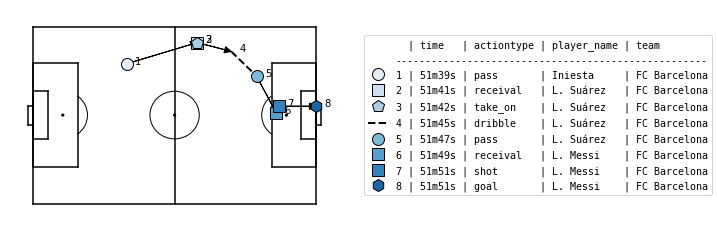

In [24]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [25]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [26]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


### Compute Probabilities

In [27]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [28]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y


## Model 

In [29]:
### load model 
import pickle
model = pickle.load(open('trained_model.sav', 'rb'))

In [30]:
#Prediction per tutte le partite
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 380/380 [00:03<00:00, 98.39it/s] 


In [31]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 380/380 [00:08<00:00, 47.49it/s]


## VAEP

In [32]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


In [33]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 380/380 [00:24<00:00, 15.73it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [34]:
#Df with players and roles
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

df_players = pd.merge(df_players, teams, left_on = 'currentTeamId', right_on = 'team_id').drop(['currentTeamId','team_id','team_name'], axis = 1).rename(columns={'team_name_short':'Team'})

In [35]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "Team","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count
41,3359,L. Messi,Forward,Barcelona,48.167136,47.876719,0.290417,4947
241,7972,L. Suárez,Forward,Barcelona,37.018932,36.013478,1.005455,2850
26,3322,Cristiano Ronaldo,NaN,NaN,30.994976,30.543175,0.451801,2182
135,3840,Iago Aspas,Forward,Celta de Vigo,27.480997,26.420945,1.060052,3229
108,3682,A. Griezmann,Forward,Atl\u00e9tico Madrid,24.155244,22.372832,1.782412,2549
522,395636,Maxi Gómez,Forward,Celta de Vigo,23.873090,22.809967,1.063123,1689
213,5400,Gerard Moreno,Forward,Espanyol,23.725037,22.629167,1.095871,3153
502,355599,Mikel Oyarzabal,Midfielder,Real Sociedad,22.511928,20.525146,1.986783,2592
322,70129,Rodrigo,Forward,Valencia,22.424489,21.662118,0.762371,2459
19,3299,Fernando Pacheco,Goalkeeper,Deportivo Alav\u00e9s,21.627831,2.612235,19.015596,1712


In [36]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1400] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
40,3359,L. Messi,Forward,Barcelona,48.167136,47.876719,0.290417,4947,3127,1.386326,1.377968,0.008359
25,3322,Cristiano Ronaldo,NaN,NaN,30.994976,30.543175,0.451801,2182,2382,1.171095,1.154024,0.017071
240,7972,L. Suárez,Forward,Barcelona,37.018932,36.013478,1.005455,2850,3015,1.105043,1.075029,0.030014
243,8278,G. Bale,Forward,Real Madrid,19.509810,19.334226,0.175584,2047,1872,0.937972,0.929530,0.008442
107,3682,A. Griezmann,Forward,Atl\u00e9tico Madrid,24.155244,22.372832,1.782412,2549,2606,0.834218,0.772661,0.061557
134,3840,Iago Aspas,Forward,Celta de Vigo,27.480997,26.420945,1.060052,3229,3056,0.809323,0.778104,0.031219
321,70129,Rodrigo,Forward,Valencia,22.424489,21.662118,0.762371,2459,2785,0.724669,0.700033,0.024637
501,355599,Mikel Oyarzabal,Midfielder,Real Sociedad,22.511928,20.525146,1.986783,2592,2877,0.704231,0.642080,0.062152
414,250885,Santi Mina,Forward,Valencia,12.452973,12.174843,0.278130,1261,1634,0.685904,0.670585,0.015319
84,3563,Isco,Midfielder,Real Madrid,14.011722,13.082495,0.929227,3699,1839,0.685729,0.640253,0.045476


In [37]:
copy = stats.sort_values("vaep_rating",ascending=False)[:10].copy()
copy[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
40,L. Messi,Forward,Barcelona,1.386326
25,Cristiano Ronaldo,NaN,NaN,1.171095
240,L. Suárez,Forward,Barcelona,1.105043
243,G. Bale,Forward,Real Madrid,0.937972
107,A. Griezmann,Forward,Atl\u00e9tico Madrid,0.834218
134,Iago Aspas,Forward,Celta de Vigo,0.809323
321,Rodrigo,Forward,Valencia,0.724669
501,Mikel Oyarzabal,Midfielder,Real Sociedad,0.704231
414,Santi Mina,Forward,Valencia,0.685904
84,Isco,Midfielder,Real Madrid,0.685729


In [38]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Goalkeeper'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
129,Sergio Álvarez,Goalkeeper,Celta de Vigo,0.654307
333,L. Chichizola,Goalkeeper,Las Palmas,0.633591
55,Sergio Asenjo,Goalkeeper,Villarreal,0.593740
17,Adán,Goalkeeper,Real Betis,0.589028
269,Neto,Goalkeeper,Valencia,0.559471
18,Fernando Pacheco,Goalkeeper,Deportivo Alav\u00e9s,0.554086
330,G. Rulli,Goalkeeper,Real Sociedad,0.538524
147,Cuéllar,Goalkeeper,Legan\u00e9s,0.534140
115,Roberto,Goalkeeper,M\u00e1laga,0.507315
6,Guaita,Goalkeeper,Getafe,0.501201


In [39]:
#dif 
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Defender'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
22,Marcelo,Defender,Real Madrid,0.459738
444,Aritz Elustondo,Defender,Real Sociedad,0.424856
324,Luisinho,Defender,Deportivo La Coru\u00f1a,0.379362
63,Coke,Defender,Levante,0.367676
20,Sergio Ramos,Defender,Real Madrid,0.350879
57,Filipe Luis,Defender,Atl\u00e9tico Madrid,0.341739
26,Juanfran,Defender,Deportivo La Coru\u00f1a,0.334072
99,Íñigo Martínez,Defender,Athletic Club,0.329210
225,Bustinza,Defender,Legan\u00e9s,0.312943
67,Juan Cala,Defender,Las Palmas,0.309191


In [40]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Midfielder'][['player_name','Role','Team','vaep_rating']][:10]

,player_name,Role,Team,vaep_rating
501,Mikel Oyarzabal,Midfielder,Real Sociedad,0.704231
84,Isco,Midfielder,Real Madrid,0.685729
460,E. Bardhi,Midfielder,Levante,0.619483
474,Marco Asensio,Midfielder,Real Madrid,0.580324
248,T. Kroos,Midfielder,Real Madrid,0.563544
155,Pablo Sarabia,Midfielder,Sevilla,0.543981
357,Samu Castillejo,Midfielder,Villarreal,0.498209
386,José Luis Morales,Midfielder,Levante,0.487603
13,Portu,Midfielder,Girona,0.473683
74,Raúl García,Midfielder,Athletic Club,0.453200


In [41]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Role == 'Forward'][['player_name','Role','Team','vaep_rating']][:10]
#Manca ronaldo perchè è Nan

,player_name,Role,Team,vaep_rating
40,L. Messi,Forward,Barcelona,1.386326
240,L. Suárez,Forward,Barcelona,1.105043
243,G. Bale,Forward,Real Madrid,0.937972
107,A. Griezmann,Forward,Atl\u00e9tico Madrid,0.834218
134,Iago Aspas,Forward,Celta de Vigo,0.809323
321,Rodrigo,Forward,Valencia,0.724669
414,Santi Mina,Forward,Valencia,0.685904
521,Maxi Gómez,Forward,Celta de Vigo,0.676291
297,C. Bacca,Forward,Villarreal,0.668022
271,S. Zaza,Forward,Valencia,0.663010


In [42]:
copy = stats.sort_values("vaep_rating",ascending=False).copy()
copy[copy.Team == 'Real Madrid'][['player_name','Role','Team','vaep_rating']][:320]

,player_name,Role,Team,vaep_rating
243,G. Bale,Forward,Real Madrid,0.937972
84,Isco,Midfielder,Real Madrid,0.685729
474,Marco Asensio,Midfielder,Real Madrid,0.580324
248,T. Kroos,Midfielder,Real Madrid,0.563544
192,Lucas Vázquez,Forward,Real Madrid,0.523937
24,K. Benzema,Forward,Real Madrid,0.483512
22,Marcelo,Defender,Real Madrid,0.459738
141,K. Navas,Goalkeeper,Real Madrid,0.451029
20,Sergio Ramos,Defender,Real Madrid,0.350879
303,Casemiro,Midfielder,Real Madrid,0.339289


#### Salary

In [49]:
spa = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/la-liga/2017-2018/all_la-liga_2017-2018.xlsx')
spa = spa[spa['Annual Gross(IN EUR)']>0]
spa = spa.drop_duplicates(subset=["Player"], keep='last')
spa.drop('Unnamed: 0', axis = 1, inplace = True)
spa['Name'] = [spa['Player'][i-1:i].values[0].split()[0] for i in range(1,len(spa.Player)+1)]
spa['Surname'] = [spa['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(spa.Player)+1)]

players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[1] for i in range(1,len(players.player_name)+1)]
giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)
giocatori = giocatori[giocatori['minutes_played']>1500]

df = pd.merge(giocatori,spa, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]
missing = pd.merge(df,spa, left_on = 'player_id', right_on = 'ID')
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.drop('player_id', axis = 1)
df['vaep/salary'] = df['vaep_value']*10**4/ df['Salary']
df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean()

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,27.103448,15.792353,15.049041,0.743311,1883.618182,2301.109091,0.596257,6.523517e+06,0.0576


In [50]:
display(spa[spa['Role']=='D'].sort_values('Annual Gross(IN EUR)',ascending = False)[:5])
display(spa[spa['Role']=='F'].sort_values('Annual Gross(IN EUR)',ascending = False)[:5])

,ID,Player,Annual Gross(IN EUR),Adj. Gross(IN EUR),Role,Age,Country,Team,League,Season,Name,Surname
514,NaN,Sergio Ramos,18460000,18529153,D,31,Spain,Real Madrid,La Liga,2017-2018,Sergio,Ramos
108,NaN,Gerard Piqué,12619000,12666272,D,30,Spain,Barcelona,La Liga,2017-2018,Gerard,Piqué
110,NaN,Sergi Roberto,9871000,9907978,D,25,Spain,Barcelona,La Liga,2017-2018,Sergi,Roberto
543,NaN,Iñigo Martínez,8884000,8917280,D,26,Spain,Real Sociedad,La Liga,2017-2018,Iñigo,Martínez
111,NaN,Jordi Alba,8499000,8530838,D,28,Spain,Barcelona,La Liga,2017-2018,Jordi,Alba


,ID,Player,Annual Gross(IN EUR),Adj. Gross(IN EUR),Role,Age,Country,Team,League,Season,Name,Surname
102,3359,Lionel Messi,39621000,39769423,F,30,Argentina,Barcelona,La Liga,2017-2018,Lionel,Messi
511,3322,Cristiano Ronaldo,34847000,34977540,F,32,Portugal,Real Madrid,La Liga,2017-2018,Cristiano,Ronaldo
512,8278,Gareth Bale,27677000,27780680,F,27,Wales,Real Madrid,La Liga,2017-2018,Gareth,Bale
104,7972,Luis Suárez,23179000,23265830,F,30,Uruguay,Barcelona,La Liga,2017-2018,Luis,Suárez
103,NaN,Philippe Coutinho,23179000,23265830,F,25,Brazil,Barcelona,La Liga,2017-2018,Philippe,Coutinho


In [63]:
spa.groupby('Team').max()

/var/folders/wj/rf_7mtyj4mz92p07_kctx9t80000gn/T/ipykernel_2739/2770804281.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  spa.groupby('Team').max()


,Player,Annual Gross(IN EUR),Adj. Gross(IN EUR),Role,Age,Country,League,Season,Name,Surname
Team,,,,,,,,,,
Alaves,Víctor López,1237000,1241634,M,31,Venezuela,La Liga,2017-2018,Víctor,Wakaso
Athletic Club,Óscar de Marcos,5717000,5738416,M,36,Spain,La Liga,2017-2018,Óscar,Williams
Atletico Madrid,Ángel Correa,21265000,21344660,M,33,Uruguay,La Liga,2017-2018,Ángel,Werner
Barcelona,Yerry Mina,39621000,39769423,M,33,Uruguay,La Liga,2017-2018,Yerry,Vidal
Celta Vigo,Álex Mozo,3587000,3600437,M,33,Turkey,La Liga,2017-2018,Álex,Álvarez
Deportivo,Zakaria Bakkali,5122000,5141187,M,35,Uruguay,La Liga,2017-2018,Zakaria,Valverde
Eibar,Ángel López,1351000,1356061,M,33,Spain,La Liga,2017-2018,Ángel,Ángel
Espanyol,Víctor Sánchez,4330000,4346221,M,35,Spain,La Liga,2017-2018,Víctor,Vilà
Getafe,Álvaro Jiménez,1733000,1739492,M,37,Uruguay,La Liga,2017-2018,Álvaro,Suárez


In [69]:
spa.groupby('Team').sum().sort_values('Annual Gross(IN EUR)')

,Annual Gross(IN EUR),Adj. Gross(IN EUR),Age
Team,,,
Alaves,12299000,12345073,556
Getafe,12415000,12461507,522
Girona,13554000,13604775,463
Eibar,15672000,15730706,648
Levante,17046600,17114203,550
Las Palmas,19400000,19472671,590
Deportivo,19839000,19913315,520
Real Betis,24851000,24944093,565
Malaga,24972000,25065546,637


In [73]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:5]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:7]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]
top_11 = gk.append(dif).append(cen).append(att).sort_values(['Role','vaep_rating'],ascending = False)
top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
88,Enis Bardhi,21.0,Midfielder,Levante,0.619483,"641,000",0.176535
253,Portu,25.0,Midfielder,Girona,0.473683,"826,000",0.197336
84,Joan Jordán,22.0,Midfielder,Eibar,0.431942,"675,000",0.179887
89,Francisco Portillo,27.0,Midfielder,Getafe,0.328644,"618,000",0.151795
104,Pere Pons,24.0,Midfielder,Girona,0.130981,"283,000",0.137050
105,Leandro Chichizola,27.0,Goalkeeper,Las Palmas,0.633591,"247,000",0.723941
58,Antonio Adán,30.0,Goalkeeper,Real Betis,0.589028,"1,184,000",0.156875
83,Fernando Pacheco,25.0,Goalkeeper,Deportivo Alav\u00e9s,0.554086,"675,000",0.320412
74,Iván Cuéllar,33.0,Goalkeeper,Legan\u00e9s,0.534140,"820,000",0.236744
47,Vicente Guaita,30.0,Goalkeeper,Getafe,0.501201,"1,580,000",0.110391


In [74]:
d = df[df['Role']=='Defender'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
a = df[df['Role']=='Forward'].sort_values('Salary',ascending = False)[['Player','Age','Role','Team','vaep_rating','Salary','vaep/salary']][:5].reset_index(drop = True)
sal = pd.concat([d,a])
sal['Salary'] = sal['Salary'].astype(int).map('{:,}'.format)
sal

,Player,Age,Role,Team,vaep_rating,Salary,vaep/salary
0,Sergio Ramos,31.0,Defender,Real Madrid,0.350879,"18,460,000",0.005058
1,Gerard Piqué,30.0,Defender,Barcelona,0.289747,"12,619,000",0.006975
2,Sergi Roberto,25.0,Defender,Barcelona,0.154265,"9,871,000",0.004032
3,Jordi Alba,28.0,Defender,Barcelona,0.231405,"8,499,000",0.008640
4,Raphaël Varane,24.0,Defender,Real Madrid,0.203981,"8,254,000",0.006656
0,Lionel Messi,30.0,Forward,Barcelona,1.386326,"39,621,000",0.012157
1,Gareth Bale,27.0,Forward,Real Madrid,0.937972,"27,677,000",0.007049
2,Luis Suárez,30.0,Forward,Barcelona,1.105043,"23,179,000",0.015971
3,Antoine Griezmann,26.0,Forward,Atl\u00e9tico Madrid,0.834218,"21,265,000",0.011359
4,Karim Benzema,29.0,Forward,Real Madrid,0.483512,"16,387,000",0.007344


In [55]:
df[df['Role'].isna()]

,Player,Age,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
0,Cristiano Ronaldo,32.0,NaN,NaN,30.994976,30.543175,0.451801,2182,2382,1.171095,34847000.0,0.008895
5,Andrés Iniesta,33.0,NaN,NaN,6.352553,5.532137,0.820416,3510,1926,0.296848,15967000.0,0.003979
27,Nordin Amrabat,30.0,NaN,NaN,5.539416,6.314486,-0.775071,1548,1690,0.294998,2600000.0,0.021305
55,Celso Borges,29.0,NaN,NaN,7.274688,5.204441,2.070247,2628,2402,0.272574,1308000.0,0.055617
61,Fayçal Fajr,28.0,NaN,NaN,7.237814,6.102328,1.135486,2464,2514,0.259110,1125000.0,0.064336
120,NaN,NaN,NaN,NaN,17.162743,1.609672,15.553071,1870,2829,0.546005,NaN,NaN
144,NaN,NaN,NaN,NaN,8.802969,6.413904,2.389065,2324,1993,0.397525,NaN,NaN
157,NaN,NaN,NaN,NaN,4.253812,1.732313,2.521499,2571,2225,0.172064,NaN,NaN
162,NaN,NaN,NaN,NaN,10.391420,9.463538,0.927881,3447,2083,0.448981,NaN,NaN
178,NaN,NaN,NaN,NaN,6.877952,4.086871,2.791082,3890,2323,0.266473,NaN,NaN


In [53]:
#aggiungi ronaldo

# Plot

In [22]:
all_games = pd.DataFrame()
for game in tqdm.tqdm(games.game_id, desc="Loading actions"):
    actions = atomicspadl.add_names(pd.HDFStore(spadl_h5) [f"actions/game_{game}"])[['type_name','bodypart_name']]
    all_games = all_games.append(actions)

all_games = all_games.groupby('type_name').count().rename(columns = {'bodypart_name':'Count'}).sort_values('Count', ascending = False)

Loading actions: 100%|██████████| 380/380 [00:40<00:00,  9.31it/s]


In [23]:
all_games

,Count
type_name,
pass,314512
receival,273011
interception,85418
dribble,59506
out,17804
throw_in,15905
cross,12583
freekick,12283
take_on,11167


Text(0, 0.5, 'Action')

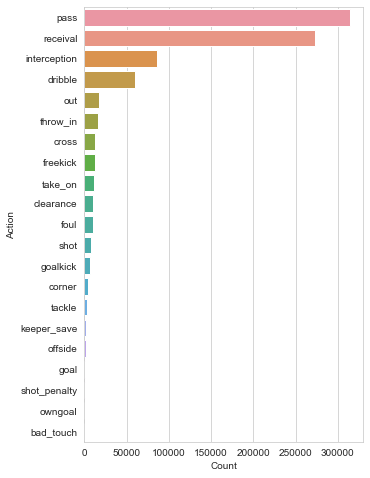

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize = (5,8))
sns.barplot(data = all_games, x = all_games.Count, y = all_games.index)
plt.ylabel('Action')